# Import Modules

In [1]:
# coding: utf-8
import gc

import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data Preprocessing 

In [186]:
def inReshapeMulLoc(data, nTs, nPred, nF):
    data_wide = data.pivot_table(index=['lng', 'lat'], columns='time', fill_value=0)
    data_wide = np.clip(data_wide.reset_index().values, 0, 200)
    del data
    gc.collect()

    nL = data_wide.shape[0]
    nS = int((data_wide.shape[1] - 2) / 2)
    nD = int(nS / nTs) - int(nPred/24)

    X = np.zeros([nL * nD, nTs, nF + 2], dtype='float32')
    Y = np.zeros([nL * nD, nPred], dtype='float32')

    for i in range(data_wide.shape[0]):
        row = data_wide[i]

        X_sub = np.zeros([nS, nF + 2], dtype='float32')
        X_sub[:, 0] = row[0]
        X_sub[:, 1] = row[1]
        for j in range(nF):
            X_sub[:, 2 + j] = row[2 + nS * j:2 + nS * (j + 1)]

        X[i * nD:(i + 1) * nD] = [X_sub[k * nTs:(k + 1) * nTs] for k in range(nD)]
        Y[i * nD:(i + 1) * nD] = [X_sub[:, 2][(k + 1) * nTs:((k + 1) * nTs + nPred)] for k in range(nD)]

    return X, Y


from random import shuffle
def shuffle_samples(X, Y):
    indices = list(range(len(X)))
    shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    return X, Y

def set_sample_weight(y):

    if (y < 20):
        wt = 0.001
    elif (y >= 20 and y < 50):
        wt = 0.1
    elif (y >= 50 and y < 100):
        wt = 10
    elif (y >= 100 and y < 500):
        wt = 100
    elif (y >= 500 and y < 1000):
        wt = 100
    else:
        wt = 0.001

    return wt


In [83]:
def inReshapeMulLoc1(data, nTs, nPred, nF):
    data_wide = data.pivot_table(index=['lng', 'lat'], columns='time', fill_value=0)
    data_wide = np.clip(data_wide.reset_index().values, 0, 200)
    del data
    gc.collect()

    nL = data_wide.shape[0]
    nS = int((data_wide.shape[1] - 2) / 2)
    nD = int(nS / nTs) - int(nPred/24) - 1

    X = np.zeros([nL * nD, nTs, nF + 2], dtype='float32')
    Y = np.zeros([nL * nD, nPred], dtype='float32')

    for i in range(data_wide.shape[0]):
        row = data_wide[i]

        X_sub = np.zeros([nS, nF + 2], dtype='float32')
        X_sub[:, 0] = row[0]
        X_sub[:, 1] = row[1]
        for j in range(nF):
            X_sub[:, 2 + j] = row[2 + nS * j:2 + nS * (j + 1)]

        X[i * nD:(i + 1) * nD] = [X_sub[k * nTs:(k + 1) * nTs] for k in range(nD)]
        Y[i * nD:(i + 1) * nD] = [X_sub[:, 2][(k + 2) * nTs:((k + 2) * nTs + nPred)] for k in range(nD)]

    return X, Y

In [84]:
# load data
df_data = pd.read_csv('./data/bj_s_train.csv', usecols= ['lng','lat','time', 'flow','dm'])
print('Data Loaded')
nLoc = int(df_data['lng'].unique().shape[0] * df_data['lat'].unique().shape[0])
nDay = int(df_data['time'].unique().shape[0] / 24) - 1
print('Area Size:', nLoc, 'Blocks')
print('Period:', nDay+1, 'Days')


Data Loaded
Area Size: 25 Blocks
Period: 28 Days


In [85]:
# params
nTs = 24           # number of timesteps to lookback
nPred = 24         # number of timesteps to predict
nF = 4
trn_split = 0.7        # proportion of training set
val_split = 0.25   # proporti5on of validation set
#fold = 10         # number of CV fold

In [87]:
#for i in range(X.shape[0]):
#    print(X[i],Y[i])

In [88]:
# Standarlise data
#scaler = StandardScaler().fit(df_data.iloc[:, 3:5])
#df_data.iloc[:,3:5] = scaler.transform(df_data.iloc[:, 3:5])

In [89]:
# Min Max Scaler
#scaler_flow = MinMaxScaler().fit(df_data.iloc[:, 4:5])
#df_data.iloc[:,4:5] = scaler_flow.transform(df_data.iloc[:, 4:5])
#scaler_dm = MinMaxScaler().fit(df_data.iloc[:, 3:4])
#df_data.iloc[:,3:4] = scaler_dm.transform(df_data.iloc[:, 3:4])

In [116]:
# partition feature and label
print('Start to Extract Feature and Label...')

X,Y = inReshapeMulLoc(df_data, nTs, nPred, nF-2)
#del df_data
#gc.collect()

print('Done! Extracted ' + str(Y.shape[0]) + ' samples.')



Start to Extract Feature and Label...
Done! Extracted 675 samples.


In [187]:
# partition train and test set
print('Partitioning Train and Test Set...')

X_seq, Y_seq = shuffle_samples(X, Y)
sample_weights = np.array(list(map(set_sample_weight,np.sum(Y,1))))
#del X, Y
#gc.collect()

print('Done')

Partitioning Train and Test Set...
Done


# Raw Data Analysis
Data from bj_dm_block_5w.csv which contains dm and flow information of 25 different location blocks in 35 days

In [92]:
import matplotlib.pyplot as plt

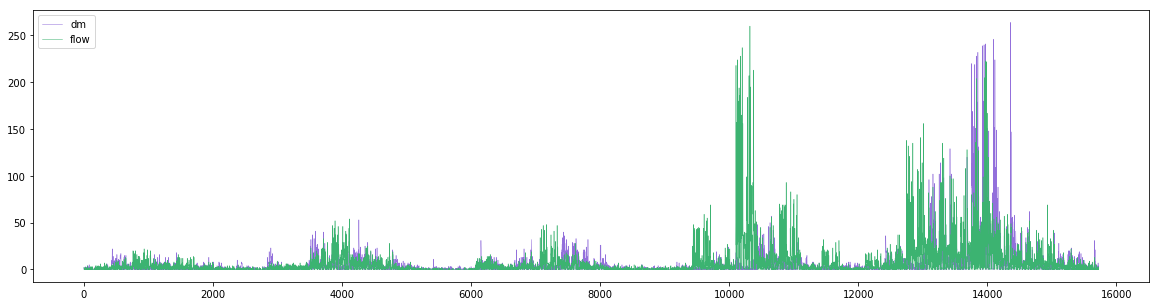

In [15]:
plt.figure(figsize=(20,5))
plt.plot(df_data['dm'], color='mediumpurple',linewidth=0.5, marker='')
plt.plot(df_data['flow'], color='mediumseagreen',linewidth=0.5, marker='')
plt.legend(['dm', 'flow'], loc='upper left', fontsize=10)
#plt.plot(df_data['ed'])
#plt.plot(df_data['st'])
plt.show()
plt.close()

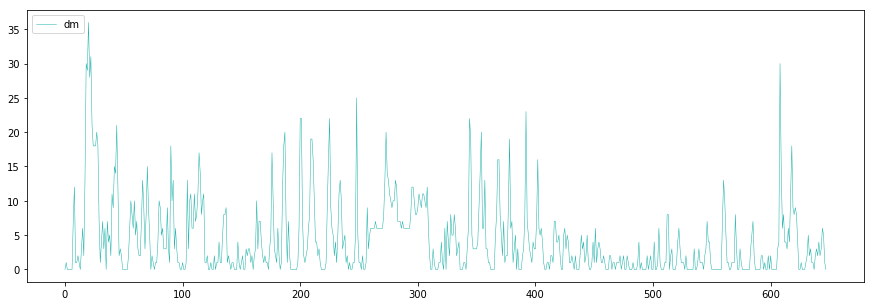

In [16]:
def plot_info_1block(df_data, info_type, loc_index):
    info = df_data.iloc[loc_index,:nDay * 24].values if info_type == 'dm' else df_data.iloc[loc_index,nDay * 24:].values
    plt.figure(figsize=(15,5))
    plt.plot(info, color='lightseagreen',linewidth=0.5, marker='')
    plt.legend([info_type], loc='upper left', fontsize=10)
    plt.show()
    plt.close()


df_datawide = df_data.pivot_table(index=['lng','lat'], columns='time', fill_value=0)
plot_info_1block(df_datawide, 'dm', 20)


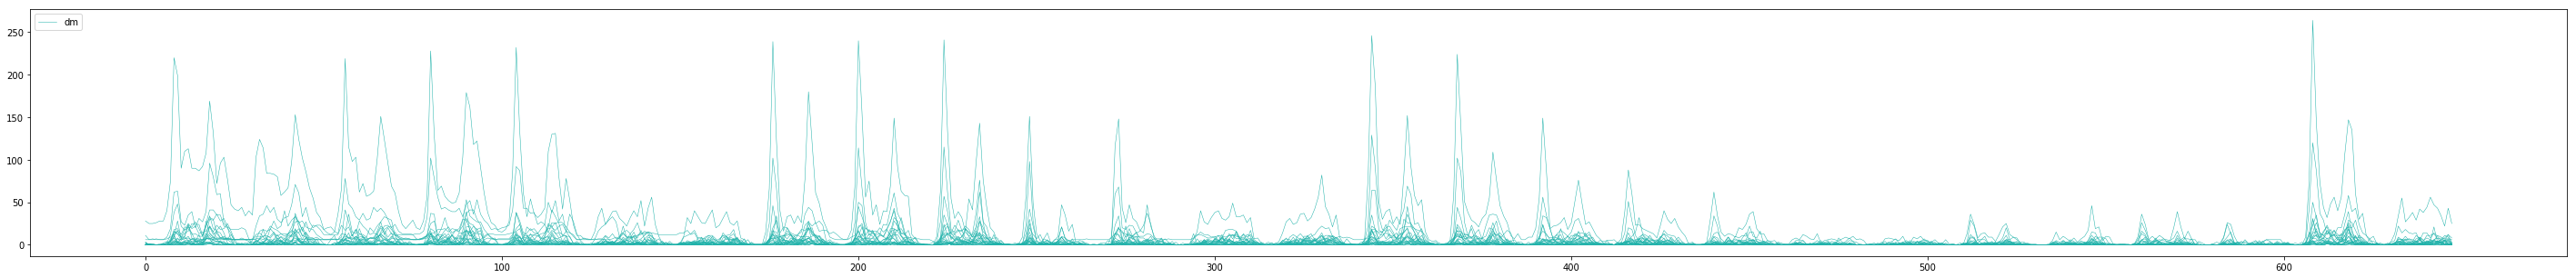

In [17]:
def plot_info_1block(df_data, info_type):
    info = df_data.iloc[:,:nDay * 24].values if info_type == 'dm' else df_data.iloc[:,nDay * 24:].values
    plt.figure(figsize=(50,5))
    for row in info:
        plt.plot(row, color='lightseagreen',linewidth=0.5, marker='')
    plt.legend([info_type], loc='upper left', fontsize=10)
    plt.show()
    plt.close()
plot_info_1block(df_datawide, 'dm')


# Model Build

In [93]:
def lstm_model():

    #define the model
    model = Sequential()

    model.add(LSTM(100, input_shape=(nTs, nF), return_sequences=False, activation = 'relu'))
    #model.add(LSTM(100, input_shape=(nTs, nF), return_sequences=False))
    #model.add(PReLU(alpha_initializer = Constant(value=0.01)))
    model.add(Dropout(0.20))

    model.add(Dense(nPred))

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    #model.compile(loss=my_msle, optimizer=adam)

    return model

def gru_model():

    #define the model
    model = Sequential()

    model.add(GRU(100, input_shape=(nTs, nF), return_sequences=True, activation = 'relu'))
    model.add(Dropout(0.20))
   
    model.add(GRU(100, return_sequences=False, activation = 'relu'))
    model.add(Dropout(0.20))
    
    model.add(Dense(nPred))

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    #model.compile(loss=my_msle, optimizer=adam)

    return model

In [94]:
def my_msle(y_true, y_pred):
    bias = 1
    first_log = K.log(K.clip(y_pred, K.epsilon(), np.inf) + bias)
    second_log = K.log(K.clip(y_true, K.epsilon(), np.inf) + bias)
    return K.mean(K.square(first_log - second_log), axis=-1)

In [194]:
#model = lstm_model()
model = gru_model()
early_stopping = EarlyStopping(monitor='val_loss',  min_delta=0, verbose=1, patience=7)

model.fit(X_seq, Y_seq,
          validation_split = val_split,
          callbacks=[early_stopping],
          sample_weight = sample_weights,
          epochs=50,
          batch_size=10,
          shuffle=True,
          verbose=2)

print('Model Training Done')

Train on 506 samples, validate on 169 samples
Epoch 1/50
5s - loss: 1693.4195 - val_loss: 1221.8858
Epoch 2/50
3s - loss: 1012.4446 - val_loss: 1662.0031
Epoch 3/50
3s - loss: 1051.0003 - val_loss: 1534.1168
Epoch 4/50
3s - loss: 1216.8087 - val_loss: 1713.1262
Epoch 5/50
3s - loss: 1344.0453 - val_loss: 1350.2456
Epoch 6/50
3s - loss: 978.1335 - val_loss: 1444.8163
Epoch 7/50
4s - loss: 710.5428 - val_loss: 1211.3889
Epoch 8/50
3s - loss: 732.0805 - val_loss: 1364.6144
Epoch 9/50
3s - loss: 957.2795 - val_loss: 1465.6808
Epoch 10/50
3s - loss: 571.2637 - val_loss: 1235.0608
Epoch 11/50
3s - loss: 728.4055 - val_loss: 1562.6444
Epoch 12/50
3s - loss: 674.8071 - val_loss: 1555.7262
Epoch 13/50
3s - loss: 526.7317 - val_loss: 1305.4517
Epoch 14/50
3s - loss: 669.7179 - val_loss: 1730.5051
Epoch 15/50
3s - loss: 547.6492 - val_loss: 2323.5284
Epoch 00014: early stopping
Model Training Done


In [195]:
pred = model.predict(X)

In [196]:
# evaluate the model on a test set
score_tr = model.evaluate(X, Y, verbose=0, sample_weight=None)
print('Training RMSE: ' + str(score_tr))

Training RMSE: 75.4957660534


In [ ]:
#pred_ogn = scaler_dm.inverse_transform(pred)
#Ytest_ogn = scaler_dm.inverse_transform(Ytest)

# Parameter setting summary

main params:  
name&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;meaning&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;bsf  
nTs&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;number of timesteps &ensp;&ensp;&ensp;&ensp;5  
act_f


# Data Visualisaiton

In [30]:
def drawPredOneHour(pred, tgt, hour):
    plt.figure(figsize=(20,5))
    plt.plot(tgt[:,hour], color='mediumpurple',linewidth=1, marker='')
    plt.plot(pred[:,hour], color='mediumseagreen',linewidth=1, marker='')
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    #for i in range(nLoc):
    #    plt.axvline(x=(i+1)*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()
    

In [31]:
def drawPredEveryHour(pred, tgt):
    plt.figure(figsize=(40,20))
    for i in range(24):
        plt.subplot(4,6,i+1)
        plt.plot(tgt[:,i], color='mediumpurple',linewidth=1, marker='')
        plt.plot(pred[:,i], color='mediumseagreen',linewidth=1, marker='')
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.show()
    plt.close()

In [32]:
def drawPredDaily(pred, tgt, day):
    plt.figure()
    plt.plot(tgt[day], color='mediumpurple',marker = "+")
    plt.plot(pred[day], color='mediumseagreen',marker = "+")
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()
    

In [33]:
def print_mae_hourly(pred, tgt):
    error_hourly = np.zeros(nPred, dtype='float32')
    for i in range(nPred):   
         error_hourly[i] = np.mean(abs(pred[:,i]-tgt[:,i]))
    plt.figure()
    plt.plot(error_hourly, color = 'lightseagreen', marker = "+")
    plt.legend(['Hourly Prediction MAE'], loc='upper right', fontsize=10)
    plt.xlabel('Hour')
    plt.ylabel('Error')
    plt.show()
    

In [54]:
def draw_pred_1blk(pred, tgt, blk_index):
    plt.figure(figsize=(15,5))
    plt.plot(tgt[blk_index*nDay:(blk_index+1)*nDay].reshape(-1), color='mediumpurple',marker = "")
    plt.plot(pred[blk_index*nDay:(blk_index+1)*nDay].reshape(-1), color='mediumseagreen',marker = "")
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)    
    for i in range(nDay):
        plt.axvline(x=(i+1)*24-1, linestyle='-.', color='k', linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()    
    

In [35]:
def drawAllPred(pred, tgt):
    plt.figure(figsize=(20,5))
    plt.plot(tgt.reshape(-1), color='mediumseagreen',marker = "")
    plt.plot(pred.reshape(-1), color='mediumpurple',marker = "")
#    for i in range(nLoc):
#        plt.axvline(x=(i+1)*24*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()

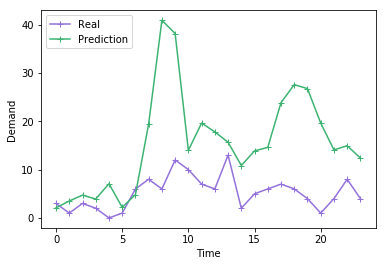

In [226]:
drawPredDaily(pred, Y, 612)

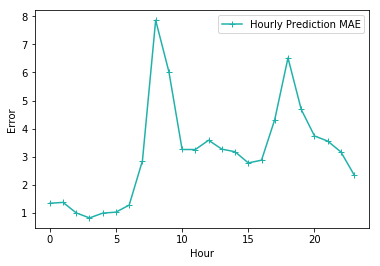

In [180]:
print_mae_hourly(pred, Y)

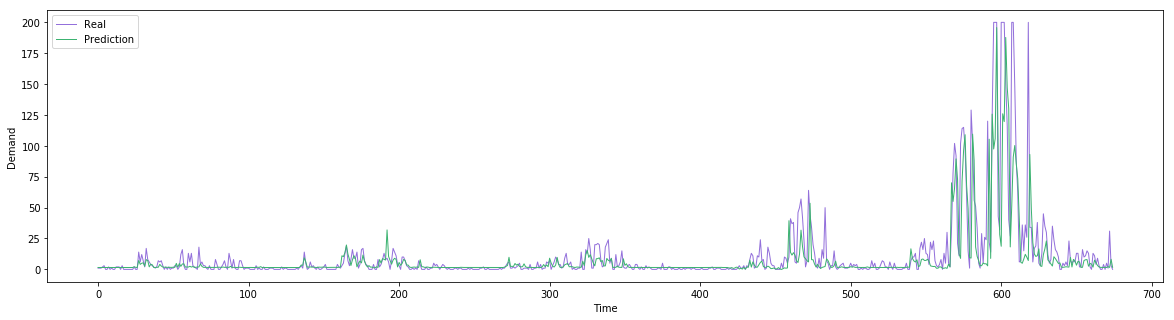

In [198]:
drawPredOneHour(pred, Y, 8)

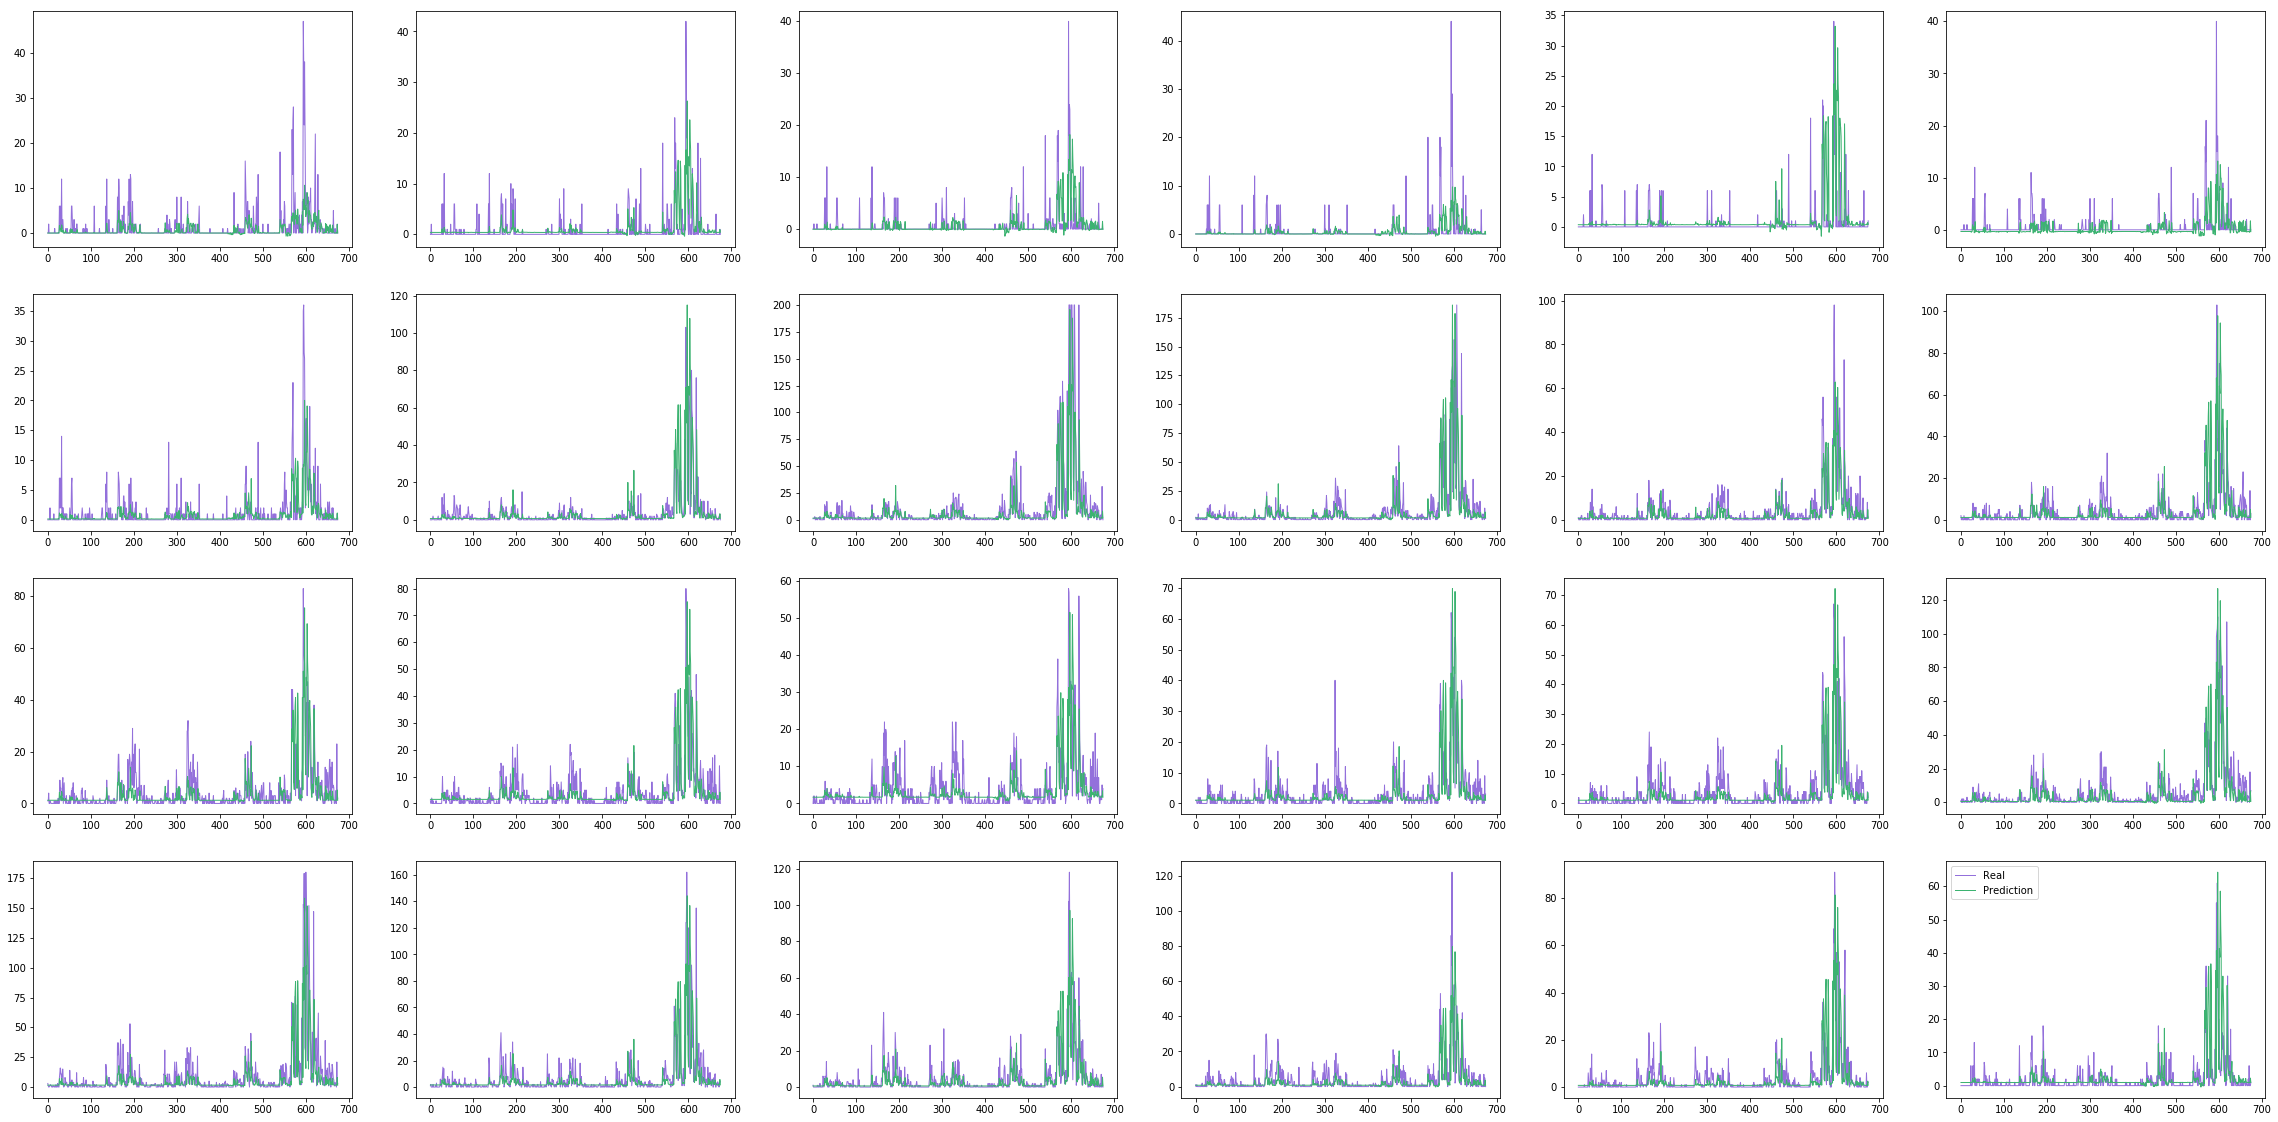

In [197]:
drawPredEveryHour(pred, Y)

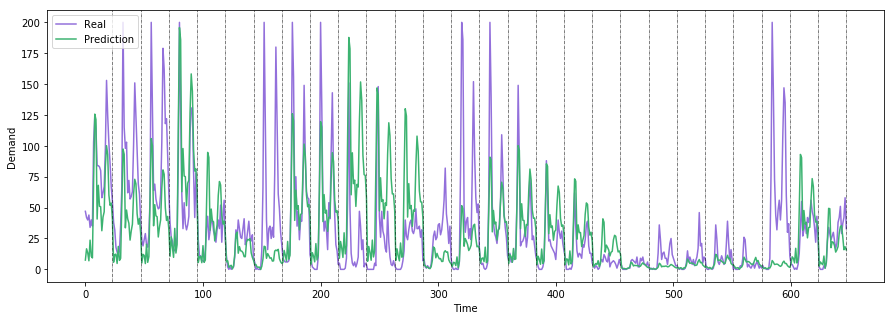

In [208]:
draw_pred_1blk(pred, Y, 22)

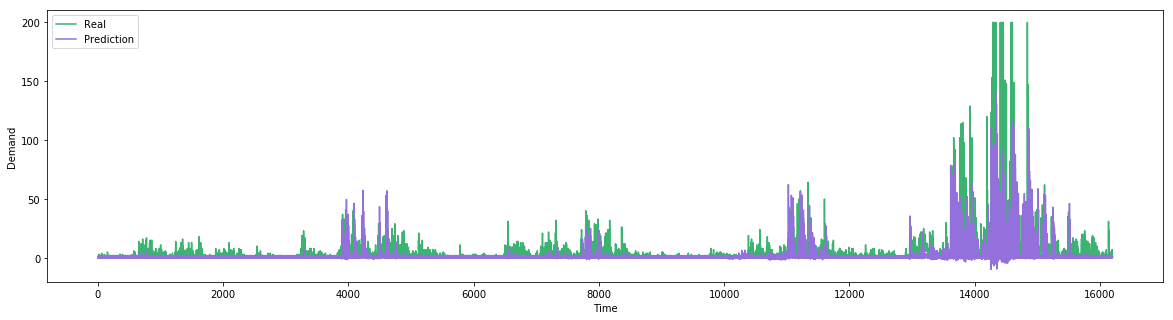

In [183]:
drawAllPred(pred, Y)

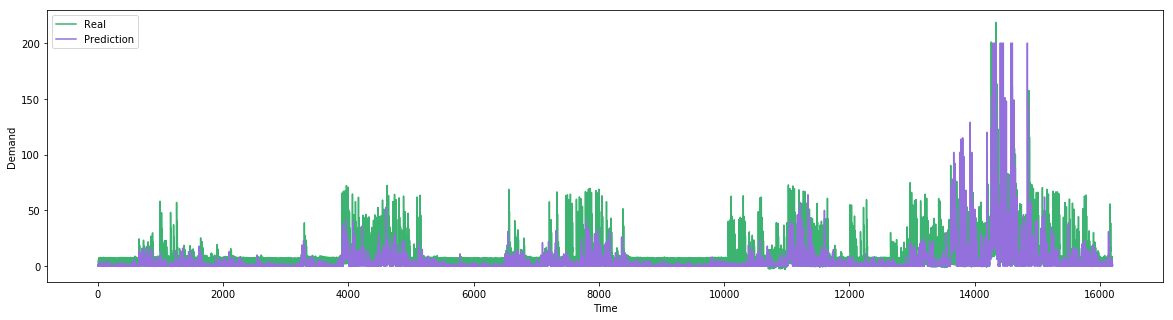

In [132]:
drawAllPred(Y, pred)

# Save Model

In [46]:
import h5py
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
